In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import gc

In [17]:
data_path = os.path.join(os.getcwd(), '../data/the-movies-dataset/')
movies = pd.read_csv(os.path.join(data_path, 'movies_preprocessed.csv'))
ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))

In [18]:
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556
(26024289, 4)


### Plot occurences of ratings per movie

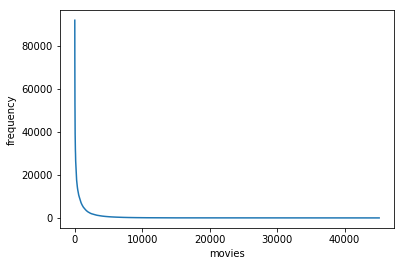

In [19]:
ratings_per_movie = ratings['movieId'].value_counts()
plt.plot(ratings_per_movie.values)
plt.xlabel('movies')
plt.ylabel('frequency')
plt.show()

The plot shows that a small amount of movies have received many ratings, whereas the most movies only got few. 

### Filter unpopular movies, and recommendations of people that don't recommed often

In [20]:
# the movie must have at least n recommendations
threshold_movie='10' 
# the movies must have received at least n recommendations
threshold_user='300'

In [22]:
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(df_movies_cnt.query('count >= '+threshold_movie).index))
movies_filter = ratings.movieId.isin(popular_movies).values

df_users_cnt = pd.DataFrame(ratings.groupby('userId').size(), columns=['count'])
active_users = list(set(df_users_cnt.query('count >= '+threshold_user).index)) 
users_filter = ratings.userId.isin(active_users).values

In [23]:
ratings_filtered = ratings[movies_filter & users_filter]

### Create pivot table

Creates a pivot table with movieIds as row indizes, userIds as column indizes and ratings in the cells

In [25]:
movie_features = ratings_filtered.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [26]:
movie_features.shape

(21255, 20260)

### Convert dataframe of movie features to scipy sparse matrix

In [28]:
movie_features_compressed = csr_matrix(movie_features.values)

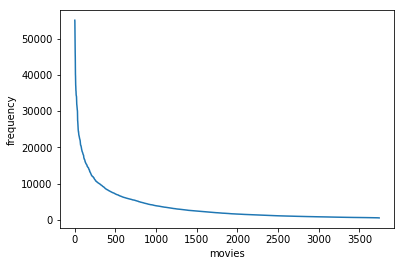

In [29]:
ratings_per_movie = ratings_subsample['movieId'].value_counts()
plt.plot(ratings_per_movie.values)
plt.xlabel('movies')
plt.ylabel('frequency')
plt.show()

### Create the model

In [32]:
k = 10
data = movie_features_compressed
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
model_knn.fit(data)

# clean up
del df_movies_cnt, df_users_cnt
del ratings, ratings_filtered, #movie_features
gc.collect()

2433

### Make recommendations

In [43]:
def recommend(movie_id, k=10):
    """Gets the id of an movie and returns the ids of the recommended movies
    @param movie_id: The movie id of the movie for which recommendations are to be made
    @type movie_id: int
    @param k: Number of neighbors that should be taken into account
    @type k: int
    @returns: A list containing the movie ids of the recommended movies 
    """
    result = []
    if movie_id in movie_features.index:
        distances, recommendations = model_knn.kneighbors(data[movie_id])
        neighbors = recommendations[0][1:]

        for neighbor in neighbors:
            if neighbor in movies['id'].values:
                result.append(neighbor)
    else:
        print('no result for given Id')
    return result[:k]

### Sample test

In [35]:
def translate_id_to_title(ids, data):
    """Translate the movieIds into the corresponding titles
    @param data: List of movie ids
    @type data: list
    @returns: A list containing the movie titles
    """
    titles = []
    for i in ids:
        titles.append(data[data['id'] == i]['title'].values[0])
    return titles

In [44]:
test_movies = [603, 13, 1726, 680, 665, 583, 103, 128]
for movie_id in test_movies:
    print('Movie: ', translate_id_to_title([movie_id], movies))
    recommendations = recommend(movie_id=movie_id)
    titles = translate_id_to_title(recommendations, movies)
    print('Recommendations:\n{}'.format(titles))
    print()

Movie:  ['The Matrix']
Recommendations:
['Double Indemnity', 'Easy Rider', 'K-PAX', 'For Your Eyes Only', "Muriel's Wedding", 'October (Ten Days that Shook the World)', 'Fat Girl', 'Tarnation']

Movie:  ['Forrest Gump']
Recommendations:
['Meet Joe Black', 'The Simpsons Movie', 'Kill Bill: Vol. 1', 'Arlington Road', 'The Wrong Trousers']

Movie:  ['Iron Man']
Recommendations:
['Asterix at the Olympic Games']

Movie:  ['Pulp Fiction']
Recommendations:
['Reservoir Dogs', 'Cruel Intentions', 'Eraserhead', 'The Man with the Golden Gun']

Movie:  ['Ben-Hur']
Recommendations:
['Double Dragon', '300', 'Crime of Passion']

Movie:  ['Life of Brian']
Recommendations:
['Drugstore Cowboy', 'Oliver Twist']

Movie:  ['Taxi Driver']
Recommendations:
['Johnny Handsome', 'Flashdance', 'The Da Vinci Code', 'Dancer in the Dark', 'Dances with Wolves', 'Gloomy Sunday']

Movie:  ['Princess Mononoke']
Recommendations:
["Who's Afraid of Virginia Woolf?", 'Life Is Beautiful', 'Pünktchen und Anton', 'Hallettsvil